# Vorticity-based diagnostics

In [1]:
# get the plot in notebook
%matplotlib inline

In [2]:
import xarray as xr
from xgcm import Grid
import numpy as np

In [3]:
ppdir = '/archive/Raphael.Dussin/xanadu_esm4_20190304_mom6_2019.08.08/OM4p25_JRA55do1.4_0netfw_cycle6/gfdl.ncrc4-intel16-prod/pp/'

In [4]:
dsgrid = xr.open_dataset(f'{ppdir}/ocean_monthly_z/ocean_monthly_z.static.nc')

A quick look at the coordinates in the static file shows that the grid is saved in non-symetric mode (see https://mom6.readthedocs.io/en/dev-gfdl/api/generated/pages/Horizontal_indexing.html for details) and that the first vorticity point is located northeast of the first center point,
in agreement with the model's conventions.

In [5]:
dsgrid

<xarray.Dataset>
Dimensions:       (xh: 1440, xq: 1440, yh: 1080, yq: 1080)
Coordinates:
  * xh            (xh) float64 -299.7 -299.5 -299.2 -299.0 ... 59.53 59.78 60.03
  * xq            (xq) float64 -299.6 -299.3 -299.1 -298.9 ... 59.66 59.91 60.16
  * yh            (yh) float64 -80.39 -80.31 -80.23 -80.15 ... 89.73 89.84 89.95
  * yq            (yq) float64 -80.35 -80.27 -80.19 -80.11 ... 89.78 89.89 90.0
Data variables:
    Coriolis      (yq, xq) float32 ...
    areacello     (yh, xh) float32 ...
    areacello_bu  (yq, xq) float32 ...
    areacello_cu  (yh, xq) float32 ...
    areacello_cv  (yq, xh) float32 ...
    deptho        (yh, xh) float32 ...
    dxCu          (yh, xq) float32 ...
    dxCv          (yq, xh) float32 ...
    dxt           (yh, xh) float32 ...
    dyCu          (yh, xq) float32 ...
    dyCv          (yq, xh) float32 ...
    dyt           (yh, xh) float32 ...
    geolat        (yh, xh) float32 ...
    geolat_c      (yq, xq) float32 ...
    geolat_u      (yh, xq)

We can then define our xgcm grid object (see https://xgcm.readthedocs.io/en/latest/ for details). Note that left/right is relative to the center point on a given axis, which means along Y up/down would translate to right/left. We also specify along which axes we need to apply periodic conditions.

In [6]:
grid = Grid(dsgrid, coords={'X': {'center': 'xh', 'right': 'xq'},
                            'Y': {'center': 'yh', 'right': 'yq'} }, periodic=['X'])

In symetric mode, we would define the grid object as:

grid = Grid(dsgrid, coords={'X': {'inner': 'xh', 'outer': 'xq'},
                            'Y': {'inner': 'yh', 'outer': 'yq'} }, periodic=['X'])


Let's open a dataset containing the velocities:

In [7]:
ds = xr.open_mfdataset(f'{ppdir}/ocean_monthly_z/ts/monthly/5yr/*.[u,v]o.nc', combine='by_coords')

## Relative vorticity

The expression for relative vorticity ($\zeta = \partial v / \partial x - \partial u / \partial y$) on the irregular grid translates to:

In [8]:
vorticity = ( - grid.diff(ds.uo * dsgrid.dxCu, 'Y', boundary='fill') 
              + grid.diff(ds.vo * dsgrid.dyCv, 'X', boundary='fill') ) / dsgrid.areacello_bu

Since the formula is evaluated lazily, it takes less than a second and
since xgcm is aware of the labels, the resulting field has the right coordinates. 

In [9]:
vorticity

<xarray.DataArray (time: 720, z_l: 35, yq: 1080, xq: 1440)>
dask.array<shape=(720, 35, 1080, 1440), dtype=float32, chunksize=(60, 35, 1079, 1439)>
Coordinates:
  * time     (time) object 1958-01-16 12:00:00 ... 2017-12-16 12:00:00
  * z_l      (z_l) float64 2.5 10.0 20.0 32.5 ... 5e+03 5.5e+03 6e+03 6.5e+03
  * yq       (yq) float64 -80.35 -80.27 -80.19 -80.11 ... 89.68 89.78 89.89 90.0
  * xq       (xq) float64 -299.6 -299.3 -299.1 -298.9 ... 59.66 59.91 60.16

We can look at surface values for the last time frame for a visual check:

In [10]:
vort_plt = vorticity.sel(z_l=2.5, time='2017-12-16')
vort_plt.load() # so that we don't recompute for each plot

<xarray.DataArray (time: 1, yq: 1080, xq: 1440)>
array([[[nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan],
        ...,
        [nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan]]], dtype=float32)
Coordinates:
  * time     (time) object 2017-12-16 12:00:00
    z_l      float64 2.5
  * yq       (yq) float64 -80.35 -80.27 -80.19 -80.11 ... 89.68 89.78 89.89 90.0
  * xq       (xq) float64 -299.6 -299.3 -299.1 -298.9 ... 59.66 59.91 60.16

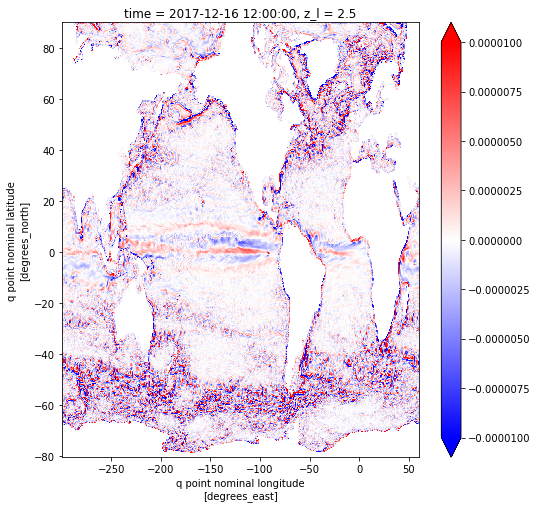

In [11]:
vort_plt.plot(figsize=[8,8], cmap='bwr', vmin=-1e-5, vmax=1e-5)

NB: This is plotted with the "nominal" longitude/latitude xq/yq. For true geographical coordinates, use geolon_c and geolat_c (grid corners).

## Potential vorticity $(\zeta + f) / h$

We need to interpolate deptho at the q-point and then this is pretty straightfoward:

In [12]:
# we interpolate in two steps, first on U-point then on Q-point
depthu = grid.interp(dsgrid.deptho, 'X', boundary='fill')
depthq = grid.interp(depthu, 'Y', boundary='fill')

In [13]:
depthq

<xarray.DataArray (yq: 1080, xq: 1440)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)
Coordinates:
  * yq       (yq) float64 -80.35 -80.27 -80.19 -80.11 ... 89.68 89.78 89.89 90.0
  * xq       (xq) float64 -299.6 -299.3 -299.1 -298.9 ... 59.66 59.91 60.16

In [14]:
Omega = 2*np.pi/86400
f0 = 2*Omega*np.sin(np.pi*45/180)
pv = (vorticity + f0) / depthq

In [15]:
pv_plt = pv.sel(z_l=2.5, time='2017-12-16')
pv_plt.load() # so that we don't recompute for each plot

<xarray.DataArray (time: 1, yq: 1080, xq: 1440)>
array([[[nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan],
        ...,
        [nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan]]], dtype=float32)
Coordinates:
  * time     (time) object 2017-12-16 12:00:00
    z_l      float64 2.5
  * yq       (yq) float64 -80.35 -80.27 -80.19 -80.11 ... 89.68 89.78 89.89 90.0
  * xq       (xq) float64 -299.6 -299.3 -299.1 -298.9 ... 59.66 59.91 60.16

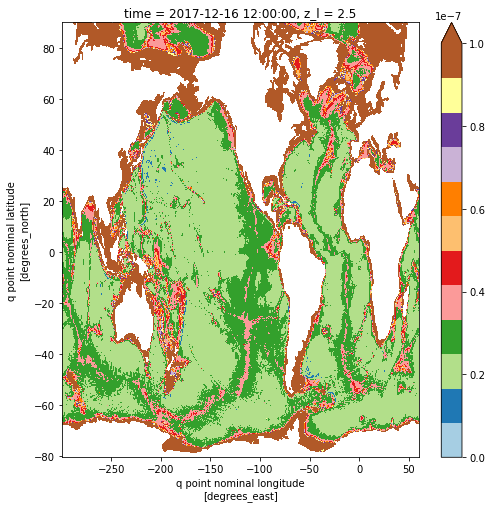

In [16]:
pv_plt.plot(figsize=[8,8], cmap='Paired', vmin=0, vmax=1e-7)